In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack
from scipy import signal
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from skimage import data
import time

plt.gray()
%matplotlib inline

# FFT Convolution
The convolution theorem states that pointwise multiplcation in the frequency domain is equivalent to convolution outside of frequency domain. Let both signals have finite support (from 0 to $N-1$ say). Then, if $\{X_k\}$ is the sequence of values in Fourier domain, $\{x_n\}$ is in time domain, $z = x\star y$, and $\omega = \exp(-2\pi j/N)$

\begin{align*}
    z_n &= \sum_{t=0}^{N-1} x_t y_{n-t} = \sum_{t=0}^{N-1} \left(\frac{1}{N}\sum_{k=0}^{N-1}X_k \omega^{-kt} \right)\left(\frac{1}{N}\sum_{l=0}^{N-1}Y_l \omega^{-l(n-t)} \right)\\
    &= \frac{1}{N} \sum_{k=0}^{N-1} X_k \sum_{l=0}^{N-1} Y_l \frac{1}{N} \sum_{t=0}^{N-1} \omega^{-kt - nl + lt)}\\
    &= \frac{1}{N} \sum_{k=0}^{N-1} X_k \sum_{l=0}^{N-1} Y_l \frac{1}{N} \sum_{t=0}^{N-1} \omega^{-ln - t(k-l)}\\
    &= \frac{1}{N} \sum_{k=0}^{N-1} X_k \sum_{l=0}^{N-1} Y_l\omega^{-nl} \frac{1}{N} \sum_{t=0}^{N-1} \omega^{- t(k-l)}\\
\end{align*}
$$
    \frac{1}{N} \sum_{t=0}^{N-1} \omega^{- t(k-l)} = \text{1 if $k=l$ else $0$}
$$
because it is a cyclic sum, so opposing parts cancel, unless $k=l$, in which case it collapses to $\sum_t 1/N=1$. Therefore, we need only consider the parts of the sum where $k=l$, so we can collapse these two into a single variable:
\begin{align*}
    z_n &= \frac{1}{N} \sum_{k=0}^{N-1} X_k Y_k\omega^{-nk}\\
    &= \frac{1}{N} \sum_{k=0}^{N-1} \left(X_k Y_k\right) \omega^{-nk}
\end{align*}
This means that $z_n$ is the inverse DFT of the pointwise product of $X$ and $Y$ in frequency space, or in other words,
$$
    \mathcal{F}\{z\} = \mathcal{F}\{x\}\mathcal{F}\{y\}
$$
proving the convolution theorem

When dealing with small kernels, it is quite efficient to directly compute convolutions, as the time taken is proportional to the number of elements in the kernel. As the kernel grows, this operation grows as $n^2$ (if the kernel is square and has size $n\times n$), so on an $M\times N$ image, the runtime is $\mathcal{O}(MNn^2)$. If we could use the FFT, an $n\log n$ operation to compute this, we can imagine that on large filters, the runtime (say we have a square image for ease of computation) for computing the FFT of the image is approximately $2N^2 \log N$. If we compute the FFT of the kernel at the same $N$, then we have a cost of around $4N^2\log N = \mathcal{O}(N^2\log N)$. This seems to indicate that if $\log N < 2n^2$ by a significant amount, convloution by FFT might be more efficient. In addition, this indicates that using the FFT for convolution has a runtime independent of size, making it ideal for large filters, in uses such as template matching.

## Observations
Here, we use the cameraman image to test this. We zero-pad the image before passing it to the FFT convolution to obtain optimal boundary behavior. We can see that the MSE difference between the two methods of convolution is essentially zero, so it seems to be a correct implementation. Because these images are real, we may use the rfft2, which keeps only half of the values in the frequency domain, as there is redundant information in the fft of a real signal. If there were a complex image or filter, we would need to use the full FFT, but as we can see in the results, it tends to take longer on average. 

In addition, in the plot of the time taken for different methods, we can see that at small filter sizes, normal convolution is much faster than FFT convolution, but as the filter size increases, the FFT convolution does not see a significant increase in running time, while the standard method increases quadratically

In [2]:
im = data.camera().astype(np.float32) / 255

In [51]:
def rfft_convolve(im, ker):
    pad_ker = np.zeros_like(im, dtype=np.float32)
    si = 0
    fudge_factor = 2*(max(ker.shape)-1)
    pad_ker[si:si+ker.shape[0], si:si+ker.shape[1]] = ker
    fft_ker = np.fft.rfft2(np.pad(pad_ker, ((0, fudge_factor), (0, fudge_factor)), 'constant'))
    fft_im = np.fft.rfft2(np.pad(im, fudge_factor//2, 'constant'))
    return np.fft.irfft2(fft_ker * fft_im)[fudge_factor: -fudge_factor//2, fudge_factor:-fudge_factor//2]
def fft_convolve(im, ker):
    pad_ker = np.zeros_like(im, dtype=np.float32)
    si = 0
    fudge_factor = 2*(max(ker.shape)-1)
    pad_ker[si:si+ker.shape[0], si:si+ker.shape[1]] = ker
    fft_ker = np.fft.fft2(np.pad(pad_ker, ((0, fudge_factor), (0, fudge_factor)), 'constant'))
    fft_im = np.fft.fft2(np.pad(im, fudge_factor//2, 'constant'))
    return np.fft.ifft2(fft_ker * fft_im)[fudge_factor: -fudge_factor//2, fudge_factor:-fudge_factor//2].real

In [52]:
fs = 31
ker = np.ones((fs, fs)) / fs**2
sker = np.ones(fs) / fs

MSE=1.44e-10


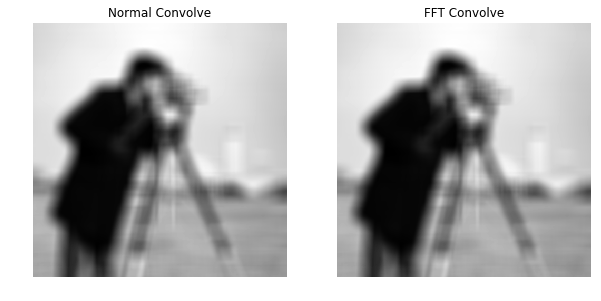

In [53]:
# Compute by convolution, circular boundaries
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
blur_im = signal.convolve2d(im, ker, mode='valid')
ax.imshow(blur_im)
ax.set_title('Normal Convolve')
ax.axis('off')

ax = plt.subplot(1, 2, 2)
res = fft_convolve(im, ker)
ax.imshow(res)
ax.set_title('FFT Convolve')
ax.axis('off')
print('MSE=%.2e'%(((res - blur_im)**2).sum()))

In [55]:
# Time different methods
fss = np.arange(1, 32)
normal_times = []
for fs in fss:
    k = np.ones((fs, fs))
    start = time.time()
    signal.convolve2d(im, k, mode='valid')
    end = time.time()
    normal_times.append(end-start)
fft_times = []
for fs in fss:
    k = np.ones((fs, fs))
    start = time.time()
    fft_convolve(im, k)
    end = time.time()
    fft_times.append(end-start)
rfft_times = []
for fs in fss:
    k = np.ones((fs, fs))
    start = time.time()
    rfft_convolve(im, k)
    end = time.time()
    rfft_times.append(end-start)

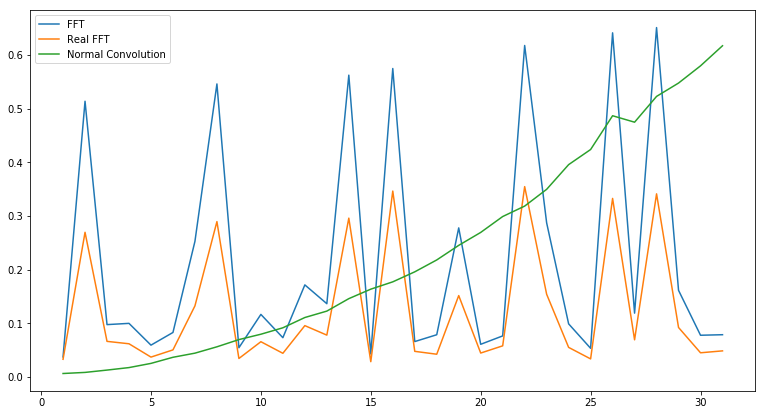

In [57]:
plt.figure(figsize=(13, 7))
plt.plot(fss, fft_times, label='FFT')
plt.plot(fss, rfft_times, label='Real FFT')
plt.plot(fss, normal_times, label='Normal Convolution')
plt.legend(loc='best')